# <b>Moduel 2 - Peak Calling and Differential Analysis</b> 
--------------------------------------------

## Overview
In this module, we will cover the analysis of m6A MeRIP-seq data. We will focus on two key steps:
1. **Peak calling** to identify regions of the genome/transcriptome that are enriched in m6A methylation, using MeRIPtools.
2. **Differential methylation analysis** to detect changes in methylation between conditions, using exomePeak2 and RADAR.

We will guide you through how to use **MeRIPtools** to call peaks and then how to perform differential analysis with two workflows: **exomePeak2** and **RADAR**, highlighting key considerations for each tool.

Finally, we’ll compare the results from the workflows, highlighting their strengths and limitations, and recommend the best approach based on your specific analysis needs.

## Learning Objectives
+ <b>Learning Objective 1</b>: Understand the distinction between peak calling and differential methylation analysis, their relationship, and the inputs/outputs required for each step. 
+ <b>Learning Objective 2</b>: Apply appropriate tools and workflows to perform peak calling and differential analysis: MeRIPtools, RADAR, ExomePeak2.
+ <b>Learning Objective 3</b>: Interpret and analyze outputs from each tool. Compare the results across the different workflows (MeRIPtools, RADAR, and exomePeak2) and understand how to integrate or cross-validate these results if needed.

## Prerequisites
You will need the following files prepared in **Tutorial 1**:

- **Alignment Files (BAM format)**: These files are output from raw reads aligned to the reference genome.
- **GTF** Annotation File: This file provides gene annotations necessary for peak calling and differential analysis.

## Outline
- **Introduction** to Peak calling and differential methylation analysis in MeRIPseq data analysis
- **Getting started**
    1. Installing R packages
    2. Setting up directory structures
    3. Prepare the Example Dataset
- **MeRIPtools workflow**
- **RADAR**: peak-calling free workflow
- **ExomePeak2**: Integrated peak calling and differential analysis
- **Methods comparison**


---
## Introduction
Analyzing MeRIP-seq data consists of two key steps: peak calling and differential methylation analysis. Peak calling identifies the regions of the genome or transcriptome that are enriched in m6A modifications, providing insights into where m6A is likely to occur. Differential methylation analysis then compares these methylation levels across different experimental conditions (e.g., control vs. treatment) to identify regions with significant changes in m6A levels. By combining these two steps, researchers can map m6A-modified regions and uncover important regulatory changes in RNA methylation associated with biological processes or disease states.

<img src="images/2-introduction.png" width=800 />

## 1. Get Started
### 1.1. Installing R packages <mark style="background-color:AntiqueWhite;">(⏰ ~30 minites)</mark>

Installation of R packages. 

In [ ]:
# Ensure BiocManager and devtools are installed
if (!require("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
    message(" --- Installation of BiocManager is done. ---")
}

if (!require("devtools", quietly = TRUE)) {
    install.packages("devtools")
    message(" --- Installation of devtools is done. ---")
}

# Function to install packages if they are not already installed
install_if_missing <- function(packages, source = "CRAN") {
    missing_packages <- packages[!packages %in% installed.packages()[, "Package"]]
    if (length(missing_packages) > 0) {
        if (source == "Bioconductor") {
            BiocManager::install(missing_packages)
        } else if (source == "GitHub") {
            sapply(missing_packages, function(x){devtools::install_github(x,build_vignettes = FALSE)})
        } else {
            install.packages(missing_packages)
        }
        message(" --- Installation of ", paste(missing_packages, collapse = ", "), " is done. ---")
    } else {
        message(" --- All specified packages are already installed. ---")
    }
}
# Bioconductor packages
bioc_packages <- c("Rsamtools", "GenomicFeatures", "DESeq2", "qvalue", "txdbmaker","BSgenome.Hsapiens.UCSC.hg38","Guitar") # "Guitar", "clusterProfiler", "org.Hs.eg.db",
install_if_missing(bioc_packages, source = "Bioconductor")
# Bioconductor packages (needed in section 5)
bioc_packages2 <- c("GenomicRanges", "ChIPpeakAnno", "VennDiagram", "rtracklayer", "ggplot2")
install_if_missing(bioc_packages2, source = "Bioconductor")

# CRAN packages
cran_packages <- c("Rcpp", "ggplot2", "doParallel", "foreach", "gplots", "RColorBrewer", "RcppArmadillo", "BH")
install_if_missing(cran_packages)

# GitHub packages
github_packages <- c("scottzijiezhang/MeRIPtools","scottzijiezhang/RADAR","ZW-xjtlu/exomePeak2")
#github_packages <- c("scottzijiezhang/MeRIPtools")
install_if_missing(github_packages, source = "GitHub")


### 1.2. Setting up directory structures

In [2]:
if (!file.exists("Tutorial_2")){
    dir.create(file.path("Tutorial_2"))
    dir.create(file.path("Tutorial_2/bam"))
    dir.create(file.path("Tutorial_2/RADAR"))
    dir.create(file.path("Tutorial_2/MeRIPtools"))
}
setwd(file.path("Tutorial_2"))
getwd()

[1] "/home/ec2-user/SageMaker/NIGMS-Sandbox-Repository-MeRIP-UH/Tutorial_2"

### 1.3. Prepare sample information
Prepare meta data and copy the alignemnt files from previous tutorial (submodule 1) and rename them.

<div style="border: 1px solid #659078; padding: 0px; border-radius: 4px;">
  <div style="background-color: #d4edda; padding: 5px; font-weight: bold;">
    <i class="fas fa-lightbulb" style="color: #0e4628;margin-right: 5px;"></i>
      <span style="color: #0e4628">Tips - Running Bash Commands in an R Notebook </span>
  </div>
  <p style="margin-left: 5px;">
In an R notebook, you can use the <code>system()</code> function to execute bash commands. However, by default, <code>system()</code> will run the command without printing the output to the notebook. To display the output, you need to capture it by adding the argument intern = TRUE. This captures the command’s output as an R character vector, which you can then print using <code>cat()</code> or another R function. </p>

  <div style="margin-left: 5px;">Here, we create a function <code>runCommand()</code> to run a bash command and capture its result:</div>

In [3]:
# Function to run a system command and print the output
runCommand <- function(cmd){
    output <- tryCatch({
        system(cmd, intern = TRUE)
    }, warning = function(w) {
        warning(paste("Warning while running command:", cmd, "\n", w))
        return(NULL)
    }, error = function(e) {
        stop(paste("Error while running command:", cmd, "\n", e))
    })
    
    if(length(output) > 0){
        cat(output, sep = "\n")
    }
}

In [4]:
# Load metadata
meta <- read.csv(file="../Tutorial_1/meta.txt", sep="\t", header=TRUE)

# Replace spaces with dots in Sample_title and remove specific text from Group
meta$sample <- gsub(" ", ".", meta$Sample_title)
meta$group <- gsub("omental | Fallopian tube", "", meta$Group)

# Construct old and new file paths
meta$old_bam <- paste0("../Tutorial_1/STAR/subset_", meta$Run, "Aligned.sortedByCoord.out.bam")
meta$new_bam <- paste0("bam/", meta$group, "_", meta$sample, ".bam")

# Rename and move the files
for(i in 1:nrow(meta)) {
   runCommand(paste0("cp ", meta$old_bam[i], " ", meta$new_bam[i]))
}

# Store sample information for further usage
meta$sample <- paste0(meta$group, "_", meta$sample)

# View modified meta
head(meta)

,Sample_title,Sample_geo_accession,Run,Group,sample,group,old_bam,new_bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2380 input,GSM3359924,SRR7763558,omental tumor,tumor_2380.input,tumor,../Tutorial_1/STAR/subset_SRR7763558Aligned.sortedByCoord.out.bam,bam/tumor_2380.input.bam
2,2343 input,GSM3359925,SRR7763559,omental tumor,tumor_2343.input,tumor,../Tutorial_1/STAR/subset_SRR7763559Aligned.sortedByCoord.out.bam,bam/tumor_2343.input.bam
3,2270 input,GSM3359926,SRR7763560,omental tumor,tumor_2270.input,tumor,../Tutorial_1/STAR/subset_SRR7763560Aligned.sortedByCoord.out.bam,bam/tumor_2270.input.bam
4,2261 input,GSM3359927,SRR7763561,omental tumor,tumor_2261.input,tumor,../Tutorial_1/STAR/subset_SRR7763561Aligned.sortedByCoord.out.bam,bam/tumor_2261.input.bam
5,2221 input,GSM3359928,SRR7763562,omental tumor,tumor_2221.input,tumor,../Tutorial_1/STAR/subset_SRR7763562Aligned.sortedByCoord.out.bam,bam/tumor_2221.input.bam
6,2186 input,GSM3359929,SRR7763563,omental tumor,tumor_2186.input,tumor,../Tutorial_1/STAR/subset_SRR7763563Aligned.sortedByCoord.out.bam,bam/tumor_2186.input.bam


In [5]:
# Define some variables
GTF_FILE <- "../Tutorial_1/gencode.v46.pri.chr11.1.5M.gtf"
SAMPLES <- unique(gsub(".input|.m6A-IP","",meta$sample)) #samplenames
BAM_DIR <-  "bam"

<p style="background-color:AntiqueWhite;">Three workflows</p>

## <b>2. MeRIPtools workflow</b>
To analyze for MeRIP-seq data, MeRIPtools expect a pair of BAM file for each sample. For each pair of BAM file, the naming convention for MeRIPtools is <code>sample.input.bam</code> for INPUT and <code>sample.m6A.bam</code> for m6A-IP or sample.m1A.bam for m1A IP sample. They key is INPUT and IP sample have the same prefix. The mid-name for IP sample can be specified in the countReads function and thus can be anything.

### 2.1 Read alignment files and count reads
After have all the files ready, the next step is to **count reads** in consecutive bins. Usually we do 50 bp bins for typical library of 20-30 Million reads. If you have deeper coverage, a smaller bin size could increase resolution of the analysis. However, for libraries of shallow coverage, larger bin size is recommended because the smaller the bin size, the less reads are sampled in a bin and therefore the larger sampling error is encountered.

In [ ]:
library("MeRIPtools")
MeRIP <- countReads(samplenames = SAMPLES,
                    gtf = GTF_FILE,
                    bamFolder = BAM_DIR,
                    outputDir =  "MeRIPtools",
                    modification = "m6A-IP",
                    fragmentLength = 37,
                    binSize = 50, 
                    strandToKeep = "opposite",
                    paired = TRUE,
                    threads = 4)
summary(MeRIP)

### 2.2 Perform peak calling for each sample.
After obtaining read count in consecutive bins, we can perform peak calling on each bin of each sample. This step will result in a matrix of logic value to indicate whether each bin is called a peak or not. The result will be stored in a <code>MeRIP.Peak</code> object and returned. Currently, two methods were implemented in MeRIPtools to call peak: (1) Binomial test and (2) Fisher's exact test. In this tutorial we will use **Binomial test**. More details about these two peak calling methods can be found in the <a href="https://scottzijiezhang.github.io/MeRIPtoolsManual/workflow.html#d)_perform_peak_calling_for_each_sample">MeRIPtools manual</a>.

In [7]:
MeRIP <- callPeakBinomial(MeRIP = MeRIP, min_counts = 15, peak_cutoff_fdr = 0.05, peak_cutoff_oddRatio = 1, threads = 4)
summary(MeRIP)

Performing Binomial test on MeRIP dataset to call peak...
MeRIP dataset of 13 samples.
The total read count for Input and IP samples are (Million reads):
      tumor_2380 tumor_2343 tumor_2270 tumor_2261 tumor_2221 tumor_2186
Input       0.01       0.02       0.03       0.02       0.01       0.01
IP          0.02       0.04       0.05       0.02       0.02       0.03
      normal_2064 normal_2013 normal_2053 normal_2005 normal_1917 normal_1850
Input        0.01        0.02        0.01        0.01        0.01        0.01
IP           0.02        0.02        0.02        0.02        0.02        0.01
      normal_2072
Input        0.01
IP           0.01

Peak calling done by Binomial test.
Input gene level count available.


### 2.3 Define joint peak for quantitative analysis.
Although peak calling has been performed for each sample, there are variations in the peaks called across samples. However, directly comparing peak-calling results (qualitative information) across samples or groups to infer changes in methylation status between conditions (e.g., identifying “emerged” or “lost” peaks) is not ideal. This approach has two major drawbacks:
- Some variations in peak-calling results reflect borderline cases where a peak is called in one group with an FDR of 0.049, but not in another group with an FDR of 0.051. The methylation levels between these two groups are not meaningfully different, though the peak-calling results might suggest otherwise.
- Peaks may be called in one group but not in another due to differential gene expression. For example, low expression of a gene in one group could result in read counts below the threshold required for peak calling, even if the IP/Input ratio is similar across groups.

Therefore, MeRIPtools recommands using quantitative analysis to identify differentially methylated regions (peaks): "On one hand, we are interested in peaks that vary across samples, so we aim to perform differential testing on the union of peaks across all samples. On the other hand, we want to exclude peaks that are called in only one sample and not in others, as these are likely to be false signals. To address this, we define a “joint peak” set that includes only peaks called in at least 2 samples (or any threshold the user defines) for comparative analysis. The joint peaks represent the union of peaks across all samples analyzed". - from <i>MeRIPtools Manual</i>

In [8]:
MeRIP <- reportJointPeak(MeRIPdata = MeRIP, joint_threshold = 2, threads = 4)
head( jointPeak(MeRIP))

# save the peaks in the BED format
write.table(jointPeak(MeRIP), "MeRIPtools/jointPeaks.bed", sep = "\t", col.names = F, row.names = F, quote = F)

Reporting joint peak at joint threshold  2 
Hyper-thread registered: TRUE 
Using 4 thread(s) to report merged report...
Time used to report peaks: 0.108044759432475 mins... 


,chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr11,494636,494685,ENSG00000023191.17,0,-,494636,494685,0,1,50,0
2,chr11,505812,506107,ENSG00000023191.17,0,-,505812,506107,0,2,"70,30","0,266"
3,chr11,506660,506709,ENSG00000023191.17,0,-,506660,506709,0,1,50,0
4,chr11,576470,576569,ENSG00000070047.13,0,+,576470,576569,0,1,100,0
5,chr11,598485,601605,ENSG00000070047.13,0,+,598485,601605,0,2,"18,32","0,3089"
6,chr11,607167,607816,ENSG00000070047.13,0,+,607167,607816,0,1,650,0




<div style="border: 1px solid #ffe69c; padding: 0px; border-radius: 4px;">
  <div style="background-color: #fff3cd; padding: 5px; font-weight: bold;">
    <i class="fas fa-exclamation-triangle" style="color: #664d03;margin-right: 5px;"></i><a style="color: #664d03">MeRIPtools for differential peaks?</a>
  </div>
  <p style="margin-left: 5px;">
MeRIPtools also offers options for detecting differentially methylated peaks, though these functions are somewhat outdated and less commonly used. The package is primarily recommended for peak calling. For more information on differential methylation analysis with MeRIPtools, please refer to their <a fref="https://scottzijiezhang.github.io/MeRIPtoolsManual/index.html">manual</a>.
  </p>
  <p>
  </p>
</div>

## 3. **RADAR** - peak-calling-free differential methylation analysis workflow

### 3.1 Read count quantification from alignment.
(This step is similar with the MeRIPtools and below is the introduction from the RADAR manual)

First, create a character vector <code>samplenames</code> to define the names of sample, which will later tells RADAR to look for input and IP file with the samplenames as prefix.

Next we need to use <code>countReads()</code> function to 
- Concatenate exons of each gene to get a “longest isoform” transcript of each gene.
- Divide transcripts into consecutive bins of user defined width. 
- Quantify reads mapped to each bin.

This step usually takes a few hours depending on the configuration of the computer and the number of thread used to count reads. In a workstation using 20 threads (Intel Xeon processer), it takes about 1 hour for this step for 15 samples. Much longer time is expected if using laptop.

<p>The parameter <code>modification = "m6A-IP"</code> tells the function to look for bam file of IP by the name samplename.m6A-IP.bam. If the user named the IP sample as samplename.IP.bam, the user should set modification = "IP". RADAR enable flexible seeting for IP sample in cases where user perform MeRIP seq on multiple modification with shared INPUT library.</p><p>The default setting for bin width to slice the transcript is <b>50bp</b>. One can set this by parameter <code>binSize = #bp</code>. For very shallow sequencing depth (e.g. less than 10M mappable reads per library), we recommand setting bin width to larger size such as 100bp to increase the number of reads countable in each bin.</p>

In [ ]:
library("RADAR")
radar_obj <- countReads(samplenames = SAMPLES,
                    gtf = GTF_FILE,
                    bamFolder = BAM_DIR,
                    outputDir =  "RADAR",
                    modification = "m6A-IP",
                    binSize = 50, 
                    strandToKeep = "opposite",
                    paired = TRUE,
                    threads = 4
)
summary(radar_obj)
#saveRDS(RADAR, file = "RADAR/radar1.rds")

### 3.2 Normalization and Filtering

During the library normalization step, the bin-level read count of input is summarized into gene-level read count. The size factor of input is calculated using “mean ratio method” implemented in DESeq2, which is then used to calculated normalized input bin-level read count. To normalize the library size of IP samples, RADAR uses top read count bins of IP and corresponding input gene-level read count to compute the estimated enrichment of each sample. This procedure is under the assumption that samples in the same study have the same IP efficiency. RADAR then normalizes the IP read counts by the estimated IP efficiency. As an sanity check, the <code>normalizeLibrary()</code> function also generate box plot of read count before and after normalizing INPUT and box plot of estimated enrichment before and after normalizing IP. This plot can be disabled by option <code>boxPlot = FALSE</code>.

Next, the <i>geneSum</i> of INPUT is used to adjust for the variation of expression level of the IP read count. This step aims to account for the variation of IP read count attributed to variation of pre-IP gene expression level.

Before the differential test, we need to filter out bins of very low read count because under sampled locus can be strongly affected by technical variation. The filtering step will also filter out bins where IP has less coverage than Input because we only care about loci where m6A is enrichment.

In [ ]:
#radar_obj <- readRDS(file = "RADAR/radar1.rds")

# normalizaion
radar_obj <- normalizeLibrary(radar_obj)
radar_obj <- adjustExprLevel(radar_obj)

#providing the experimental group to the MeRIP.RADAR object for filtering and later inferential test steps.
variable(radar_obj) <- data.frame( Group = gsub("_.*","",colnames(radar_obj@norm.input)))

# filtering
radar_obj <- filterBins(radar_obj,minCountsCutOff = 15)

### 3.3 Run Poisson Gamma Test

Now we have the pre-processed read counts matrix for testing differential methylation. To run the default PoissonGamma test, we can call the diffIP() function. However, depending on the number of bins to be processed, this step may takes minutes to hours. Thus, multi-thread is recommended (therefore, use <code>diffIP_parallel()</code>).

In [11]:
radar_obj <- diffIP_parallel(radar_obj, thread = 8)
top_bins <- extractIP(radar_obj,filtered = T)[order(rowMeans( extractIP(radar_obj,filtered = T) ),decreasing = T)[1:1000],]
radar_obj <- reportResult(radar_obj, cutoff = 0.1, Beta_cutoff = 0.5, threads=16)
# save results into a bed file

results <- results(radar_obj)
write.table(results, file = "RADAR/RADARdiffPeaks.bed", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

The predictor variable has been converted:
 tumor  tumor  tumor  tumor  tumor  tumor normal normal normal normal normal 
     0      0      0      0      0      0      1      1      1      1      1 
normal normal 
     1      1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 8 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.0109251658121745 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 16 thread(s) to report merged report...
Time used to report peaks: 0.00833273728688558 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 6 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


### 3.4 Visualize the results by Heatmap and coverage plot
**Heatmap**. To assess the pattern of variation of the MeRIP-seq data, we can plot the heatmap of methylation level (represented by the normalized IP read counts adjusted for expression level).
The belowing code shows how to plot heatmap from the radar object (<code>radar_obj</code>) for the significant bins.

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


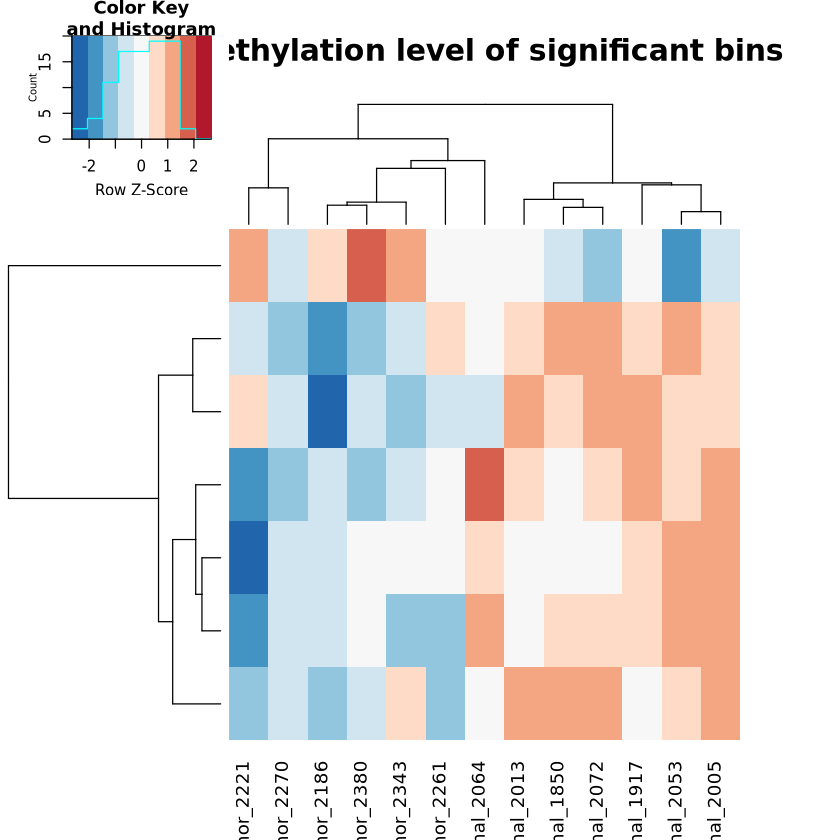

In [12]:
plotHeatMap(radar_obj)

**Sequencing coverage plot**. One of the most straight forward visualization of MeRIP-seq data is the coverage plot. RADAR implemented function to take a radar object and plot the mean/median coverage of IP and INPUT for two inferential groups. Here we demonstrate the function using a differential methylated gene reported in above sections.
To use the plot function, we need to prepare an GTF annotation in GRanges format. This can be done by <code>radar <- PrepCoveragePlot(radar)</code>. **This step only need to be done once for each radar object**.

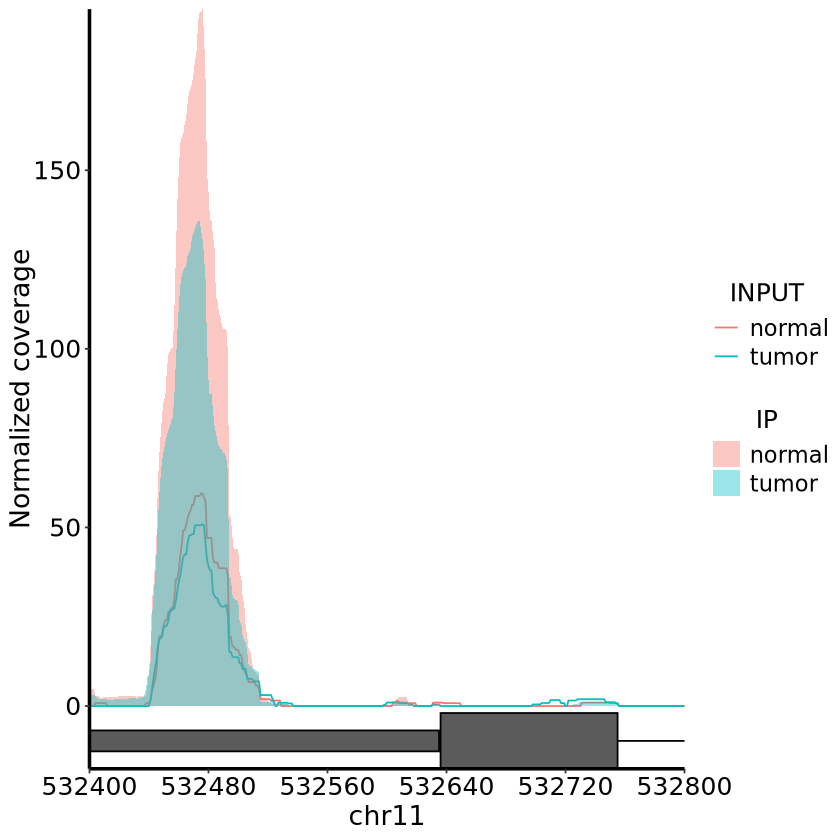

In [13]:
radar_obj <- PrepCoveragePlot(radar_obj)
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800))

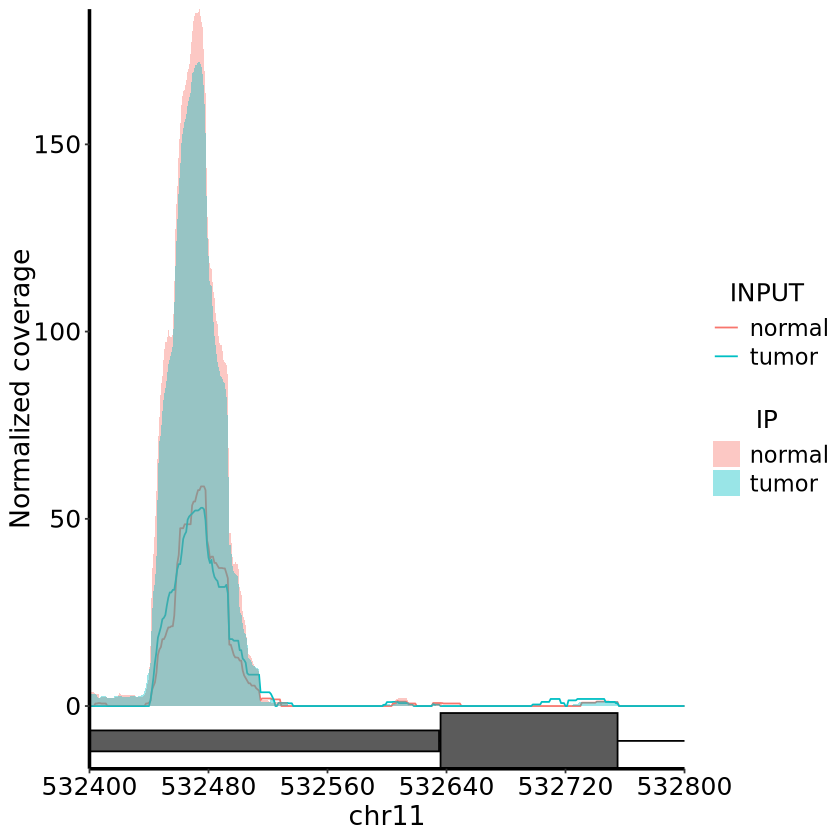

In [14]:
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800),adjustExprLevel = T )

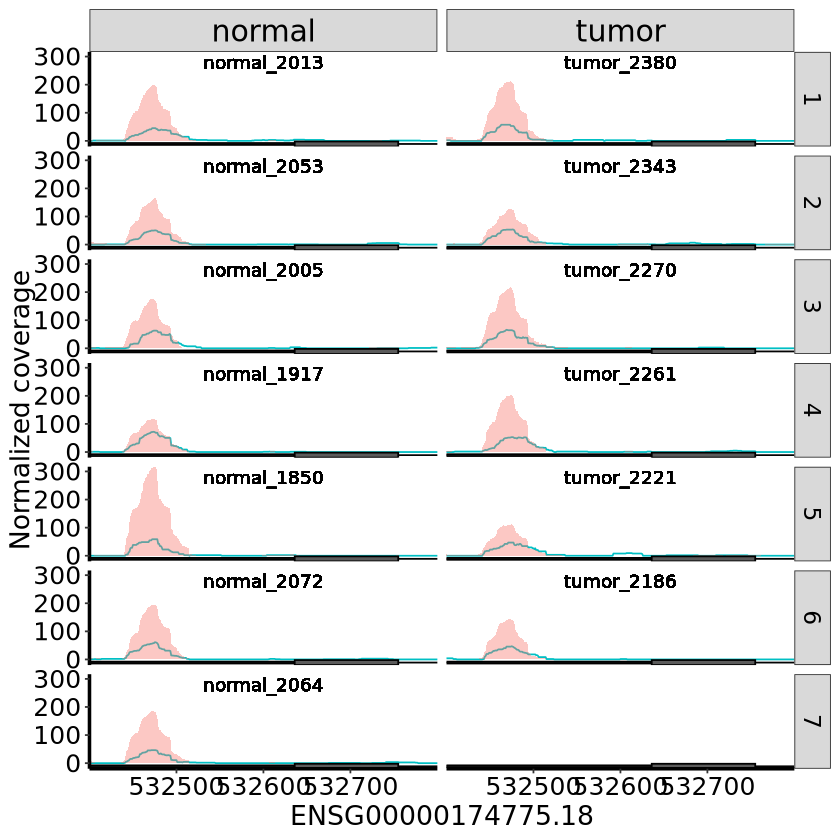

In [15]:
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800),adjustExprLevel = T,split=T )

## 4. **ExomePeak2** workflow
**ExomePeak2** provides technical independent peak detection and differential methylation analysis for Methylated RNA immunoprecipitation sequencing data (MeRIP-Seq). MeRIP-Seq is the primary sequencing technology for epi-transcriptomic assessment. The peak calling processes in MeRIP-Seq is sensitive to GC content biases, which are generally present in NGS-based assays. Besides, the antibody pull-down efficiency do often vary across different IP replicates, introducing another layer of unwanted technical variation. exomePeak2 addresses these challenges by introducing a robust set of computation tools tailored for MeRIP-Seq. With exomePeak2, users can perform peak calling and differential analysis through a straightforward single-step function. - The <i>ExomePeak2</i> Guide

For this tutorial, we use human reference genome, so the package needs to be installed. If you are using different genome later, need to install the genome as well. 

In [16]:
library(exomePeak2)
# prepare the input files
INPUT_BAM <- meta[grepl("input", meta$sample) & meta$group == "normal", "new_bam"]
IP_BAM <- meta[grepl("IP", meta$sample) & meta$group == "normal", "new_bam"]
TREATED_INPUT_BAM <- meta[grepl("input", meta$sample) & meta$group == "tumor", "new_bam"]
TREATED_IP_BAM <- meta[grepl("IP", meta$sample) & meta$group == "tumor", "new_bam"]
GENE_ANNO_GTF <- "../Tutorial_1/gencode.v46.pri.chr11.1.5M.gtf"

### 4.1 Peak calling using <code>exomePeak2</code>
For peak calling in a MeRIP-Seq experiment, **exomePeak2** requires the alignment results to be provided in **BAM** format. You need to specify the **BAM** files for IP and input samples using the arguments <code>bam_ip</code> and <code>bam_input</code> in the <code>exomePeak2()</code> function.

Below is an example of how to perform peak calling using **BAM** and **GFF** files. In addition to **GFF** files, transcript annotation can also be supplied via the **TxDb** object from <code>Bioconductor</code>. If the UCSC genome name is provided in the <code>genome</code> argument, **TxDb** will be automatically downloaded.

To correct for GC content biases, the genome sequence should be specified in the <code>genome</code> argument. If no genome is provided (i.e., <code>genome = NULL</code>), **exomePeak2** will run without GC content bias correction, which may affect peak detection.

This step below identifies peaks using the IP and input BAM files from control samples. While this step is important, note that the differential analysis in **exomePeak2** automatically performs peak calling before the differential analysis step. Therefore, we will not include this step separately when identify the differntial methylation peaks.

In [ ]:
exomePeak2(bam_ip = IP_BAM,
           bam_input = INPUT_BAM,
           gff = GENE_ANNO_GTF,
           genome = "hg38",
           experiment_name = "exomePeak2_peaks")

### 4.2. Integrated Peak calling + Differential methylated peaks - <code>ExomePeak2</code>

**Differential Methylation Analysis**

In the differential analysis step, **exomePeak2** compares IP (immunoprecipitation) and input samples across the two conditions, taking into account the RNA modifications’ fold change and statistical significance. The analysis uses regions defined by transcript annotations (e.g., exons) to focus on functional genomic elements.

The following example demonstrates how to perform differential methylation analysis using the IP and input BAM files for two biological conditions using our example dataset:

In [ ]:
exomePeak2(bam_ip = IP_BAM,
           bam_input = INPUT_BAM,
           bam_input_treated = TREATED_INPUT_BAM,
           bam_ip_treated = TREATED_IP_BAM,
           gff = GENE_ANNO_GTF,
           genome = "hg38",
           fragment_length = 37,
           p_cutoff = 0.05,
           diff_p_cutoff = 0.05,
          experiment_name = "exomePeak2_differential")

<div style="border: 1px solid #9ec5fe; padding: 0px; border-radius: 4px;">
    <div style="background-color: #cfe2ff; padding: 5px;">
        <i class="fas fa-file-alt" style="color: #052c65;margin-right: 5px;"></i>
        <a style="color: #052c65"><b>Notes</b>. exomePeak2 output </a>
    </div>
    <p style="margin-left: 5px;">
    Besides the <i>GRangesList</i> object of peaks returned by the main function, exomePeak2 will export significant peaks in <b>BED</b> and <b>CSV</b> format; the files will be automatically saved in a folder named <code>exomePeak2_output</code>.
    </p>
    <p style="margin-left: 5px;"><img src="images/2-GC_fit.jpg" width=400 />
    <p style="margin-left: 5px;">
The <b>GC_fit.pdf</b> output (figure above) from exomePeak2 is a diagnostic plot that visualizes the relationship between GC content and sequencing signal to assess and correct for GC content bias during peak calling. The X-axis represents the GC content of genomic regions, while the Y-axis shows the observed sequencing signal. The fitted curve on the plot indicates how exomePeak2 models and adjusts for GC bias, ensuring that methylation peaks are detected based on biological signals rather than sequencing artifacts. This figure helps confirm whether GC content bias is present and whether it has been properly corrected.
    </p>
</div>

## **5. Methods Comparison**
### 5.1 Peak calling methods
- macs2
- exomePeak2
- MeRIPtools

**MACS2** (Model-based Analysis for ChIP-Seq) and **exomePeak2** are two peak-calling tools used in distinct areas of genomics research, each tailored to specific data types. **MACS2** is widely used for identifying peaks from **ChIP-seq** experiments, where it aims to detect regions enriched with transcription factor binding or histone modifications. MACS2 uses a dynamic Poisson distribution to model background noise and identify statistically significant regions, making it highly effective for capturing localized DNA-protein interactions. On the other hand, **exomePeak2** is designed specifically for **RNA** modification mapping, such as m6A methylation sites, in MeRIP-seq or RIP-seq experiments. It leverages statistical models to identify differential enrichment regions across RNA transcripts, thereby enabling researchers to detect post-transcriptional modifications. While both tools share the common goal of identifying enriched genomic regions, MACS2 focuses on DNA-associated events, whereas exomePeak2 is specialized for transcriptome-wide analysis of RNA modifications.

In [19]:
#BiocManager::install(c("GenomicRanges", "ChIPpeakAnno", "VennDiagram", "rtracklayer", "ggplot2"))
# Load necessary libraries
library(GenomicRanges)
library(rtracklayer)
library(ChIPpeakAnno)
library(VennDiagram)
library(ggplot2)

Loading required package: futile.logger



In [ ]:
peaks1 <- import("../Tutorial_1/macs2/merged_peaks.bed", format = "BED")
peaks2 <- import("exomePeak2_peaks/peaks.bed", format = "BED")
peaks3 <- import ("MeRIPtools/jointPeaks.bed", format = "BED")
ol <- findOverlapsOfPeaks(peaks1,
                          peaks2,
                          peaks3,
                          ignore.strand = FALSE,
                          connectedPeaks="keepAll")
## venn diagram to show the overlaps
makeVennDiagram(ol, 
                NameOfPeaks = c("MACS2", "ExomePeak2","MeRIPtools"),
                fill = c("lightpink", "lightblue", "lightgoldenrodyellow"),
                connectedPeaks = "keepAll",
                totalTest = 1e+6)

### 5.2 Differential methylatate peaks identification methods
- RADAR
- exomePeak2

**RADAR** and **exomePeak2** are both differential peak identification tools tailored to RNA methylation studies, such as m6A methylation profiling. **exomePeak2** is designed specifically for analyzing MeRIP-seq data, focusing on the identification and quantification of RNA methylation sites across different conditions. It employs statistical models that help determine enriched methylation sites on transcripts, making it suitable for detecting differential methylation signals and their biological impact. In contrast, **RADAR** (Regression Analysis of Differential RNA m6A Methylation) extends these capabilities by using a regression framework that directly models methylation changes between different conditions while accounting for variability in read coverage, offering more robust detection of differential methylation events. Although both methods aim to detect condition-specific methylation changes, exomePeak2 provides a straightforward approach for differential peak analysis, while RADAR offers advanced modeling for more precise identification of methylation differences across biological samples.

INFO [2024-11-15 00:18:32] $fill
INFO [2024-11-15 00:18:32] [1] "yellow" "blue"  
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $cat.cex
INFO [2024-11-15 00:18:32] [1] 1
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $cat.col
INFO [2024-11-15 00:18:32] [1] "black"
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $cat.fontface
INFO [2024-11-15 00:18:32] [1] "plain"
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $cat.fontfamily
INFO [2024-11-15 00:18:32] [1] "serif"
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $x
INFO [2024-11-15 00:18:32] $x$RADAR
INFO [2024-11-15 00:18:32] [1] 149 150 151 152 153 154
INFO [2024-11-15 00:18:32] 
INFO [2024-11-15 00:18:32] $x$ExomePeak2
INFO [2024-11-15 00:18:32]   [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
INFO [2024-11-15 00:18:32]  [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
INFO [2024-11-15 00:18:32]  [37]  37  38  39  40  41  42  43  44  45  46

$p.value
     RADAR ExomePeak2         pval
[1,]     1          1 0.0004166943

$vennCounts
     RADAR ExomePeak2 Counts
[1,]     0          0    846
[2,]     0          1    148
[3,]     1          0      1
[4,]     1          1      5
attr(,"class")
[1] "VennCounts"


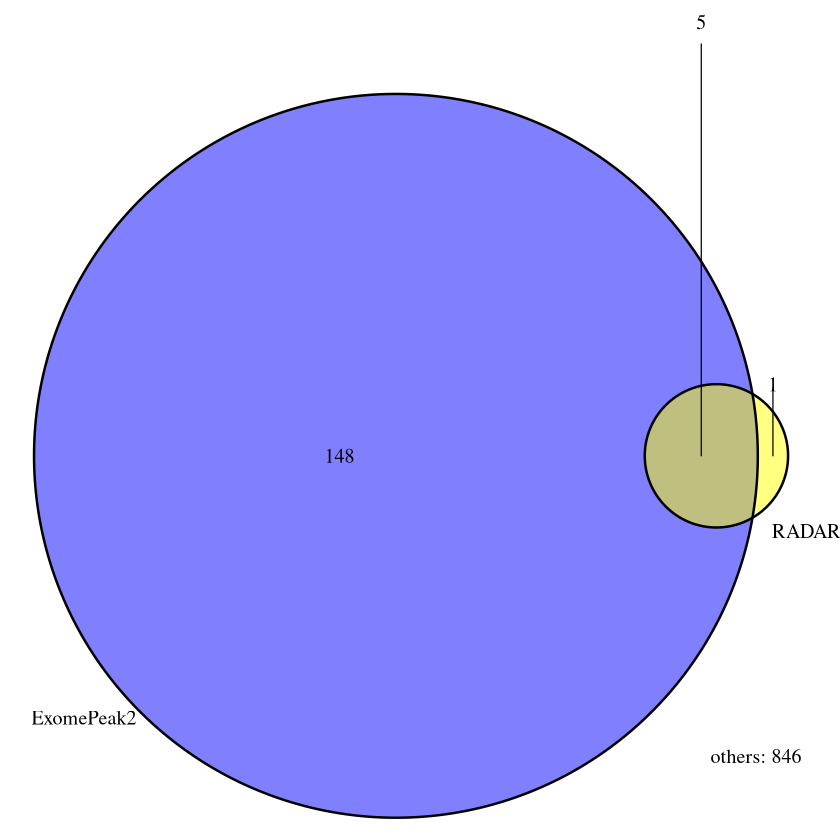

In [21]:
# Step 1: Load BED files as GRanges objects
peaks1 <- import("RADAR/RADARdiffPeaks.bed", format = "BED")
peaks2 <- import("exomePeak2_differential/diffPeaks.bed", format = "BED")

# Step 2: Find overlapping peaks between the two BED files
overlaps <- findOverlaps(peaks1, peaks2)

# Extract overlapping regions
overlapping_peaks <- pintersect(peaks1[queryHits(overlaps)], peaks2[subjectHits(overlaps)])

# Save the overlapping peaks into a BED file
simplified_peaks <- GRanges(
  seqnames = seqnames(overlapping_peaks),
  ranges = ranges(overlapping_peaks),
  strand = strand(overlapping_peaks)
)

# Export the simplified peaks as a BED file
export(simplified_peaks, "overlapping_differential_peaks.bed", format = "BED")

# Step 3: Plot Venn Diagram
#Make Venn Diagram from two or more peak ranges, Also calculate p-value to determine whether those peaks overlap significantly.

makeVennDiagram(Peaks = list(Peaks1 = peaks1, Peaks2 = peaks2),
                NameOfPeaks = c("RADAR", "ExomePeak2"),
                fill = c("yellow", "blue"),
                totalTest = 1e+3)

## Conclusion
Provide an overview of the lessons and skills learned from the module.

## Clean up
A reminder to shutdown VM and delete any relevant resources. <br><br>

<br>